# Implement smooth covariates 

In [1]:
import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# set path such that interpreter finds tigerpy
import sys
sys.path.append("..")

import tigerpy.model as tiger
import tigerpy.bbvi as bbvi
from tigerpy.distributions.mvn_degen import MulitvariateNormalDegenerate

# We use distributions and bijectors from tensorflow probability
import tensorflow_probability.substrates.jax.distributions as tfd
import tensorflow_probability.substrates.jax.bijectors as tfb

rng = np.random.default_rng(42)

# load the data
df = pd.read_csv('../data/dbbmi.csv', sep=',')

In [2]:
df

,age,bmi
0,0.03,13.235289
1,0.04,12.438775
2,0.04,14.541775
3,0.04,11.773954
4,0.04,15.325614
...,...,...
7289,21.45,19.329493
7290,21.47,21.562722
7291,21.54,23.355726
7292,21.68,24.869006


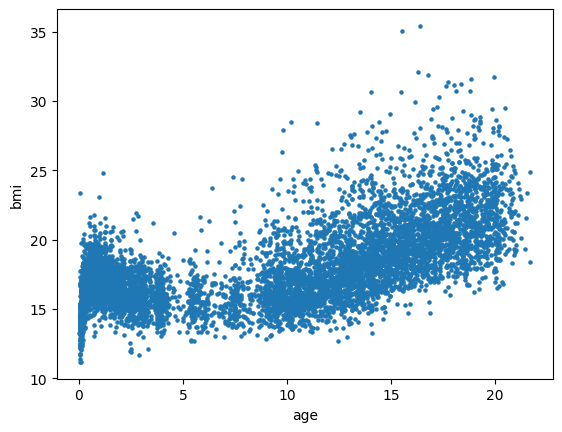

In [3]:
# plot the data
df.plot(kind = "scatter", x = "age", y = "bmi", s = 5)
plt.show()

In [4]:
# set up design matrix 
X = tiger.Obs(name = "X_loc")
X.smooth(data = df["age"].to_numpy())

# set up hyperparameters for the beta_scale  
tau_a = tiger.Hyper(0.01, name="tau_a")
tau_b = tiger.Hyper(0.01, name="tau_b")
tau_dist = tiger.Dist(tfd.InverseGamma, concentration=tau_a, scale=tau_b)
tau = tiger.Param(internal_value=jnp.log(100), distribution=tau_dist, function=jnp.exp, name="tau")

# set up hyperparameters
beta_loc = tiger.Hyper(np.zeros(X.smooth_dim), name="beta_loc")

# define the penaly matrix 
diff_mat = jnp.diff(jnp.eye(X.smooth_dim), n=2, axis=0)
pen = jnp.dot(diff_mat.T, diff_mat)

# set up parameters 
beta_dist = tiger.Dist(MulitvariateNormalDegenerate, loc=beta_loc, scale=tau, pen=pen)
beta = tiger.Param(internal_value=np.zeros(X.smooth_dim), distribution=beta_dist, name="beta")

# set up hyperparameters for the scale  
sigma_a = tiger.Hyper(0.01, name="sigma_a")
sigma_b = tiger.Hyper(0.01, name="sigma_b")

sigma_dist = tiger.Dist(tfd.InverseGamma, concentration=sigma_a, scale=sigma_b)
sigma = tiger.Param(internal_value=jnp.log(10), distribution=sigma_dist, function=jnp.exp, name="sigma")

# set up the linear predictor 
lpred = tiger.Lpred(Obs=X, beta=beta)

# set up response distribution
response_dist = tiger.Dist(tfd.Normal, loc=lpred, scale=sigma)
m = tiger.Model(response=df["bmi"].to_numpy(), distribution=response_dist)

In [5]:
m.log_prob

Array(-35791.8, dtype=float32)

In [6]:
graph = tiger.ModelGraph(Model=m)
graph.build_graph()

In [9]:
graph.DiGraph.nodes["tau"]

{'attr': {'dim': (1,),
  'internal_value': Array([4.6051702], dtype=float32, weak_type=True),
  'value': Array([100.00001], dtype=float32, weak_type=True),
  'bijector': <PjitFunction of <function jax.numpy.exp at 0x1126eb380>>,
  'dist': <tfp.distributions.InverseGamma 'InverseGamma' batch_shape=[] event_shape=[] dtype=float32>,
  'fixed_params': None,
  'log_prior': Array([-9.296852], dtype=float32)},
 'node_type': 'strong',
 'input': {'concentration': Array(0.01, dtype=float32, weak_type=True),
  'scale': Array(0.01, dtype=float32, weak_type=True)},
 'input_fixed': True,
 'pos': (155.44, 234.0),
 'label': 'tau'}

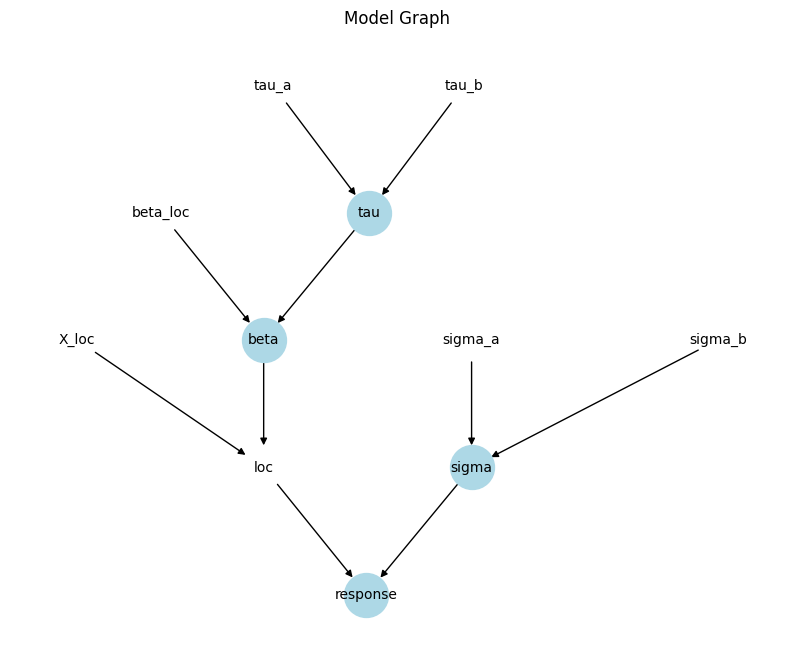

In [7]:
graph.visualize_graph()

In [10]:
def init_variational_params(joint_nodes: str):
    nodes = joint_nodes.split("_")
    mu = []
    diag = []
    for node in nodes:
        attr = graph.DiGraph.nodes[node]["attr"]
        input = graph.DiGraph.nodes[node]["input"]
        mu.append(attr["internal_value"])
        diag.append(jnp.ones(attr["dim"])*1.25)
    
    mu = jnp.concatenate(mu)
    lower_tri = jnp.diag(jnp.concatenate(diag))

    return {"mu": mu, "lower_tri": lower_tri}

In [ ]:
variational_params = {}
included = []

In [ ]:
for node in reversed(graph.prob_traversal_order):
    node_type = graph.DiGraph.nodes[node].get("node_type")
    if node_type == "strong" and node not in included:
        included.append(node)
        neighbours = list(graph.DiGraph.predecessors(node))
        neighbours_param = []
        for neighbour in neighbours:
            neighbour_node_type = graph.DiGraph.nodes[neighbour].get("node_type")
            if neighbour_node_type == "strong":
                neighbours_param.append(neighbour)
        
        included.extend(neighbours_param)
        if len(neighbours_param) >= 1:
            name = node + "_" + "_".join(neighbours_param)
            variational_params[name] = init_variational_params(name)
        else:
            variational_params[node] = init_variational_params(node)

In [41]:
variational_params

NameError: name 'variational_params' is not defined

In [ ]:
for key in joint_distributions.keys():
    print(key.split("_"))

In [ ]:
test = ["tau", "sigma"]
test.extend(["beta", "alpha"])
test

In [ ]:
graph.DiGraph.nodes["sigma"]["attr"]

## Inference with BBVI

In [29]:
q = bbvi.Bbvi(Graph=graph, num_samples=64, num_iterations=20000, key=27)

In [30]:
graph.params

{'beta': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'tau': Array([4.6051702], dtype=float32, weak_type=True),
 'sigma': Array([2.3025851], dtype=float32, weak_type=True)}

In [31]:
graph.update_graph(graph.params)

In [32]:
q.run_bbvi(step_size=0.05, threshold=1e-2, chunk_size=25)

(Array(-15716.597, dtype=float32),
 {'tau': {'mu': Array([-0.77476317], dtype=float32),
   'cov': Array([[0.01770916]], dtype=float32)},
  'sigma': {'mu': Array([0.7320485], dtype=float32),
   'cov': Array([[6.1735474e-05]], dtype=float32)},
  'beta': {'mu': Array([17.385132, 16.224089, 15.310695, 15.873812, 15.828186, 15.708376,
          15.595028, 15.60377 , 15.879671, 16.24197 , 16.532642, 16.721476,
          16.878063, 17.346285, 17.73117 , 18.138596, 18.663614, 19.165344,
          19.49199 , 19.937857, 20.453705, 20.987646, 21.427244, 21.603165,
          21.847288, 22.046154], dtype=float32),
   'cov': Array([[ 7.17998482e-03,  6.57153456e-03,  3.15278536e-03,
           -2.87952786e-03,  4.33621935e-05,  3.77277238e-03,
            2.35028868e-03,  3.59352562e-03,  2.59640953e-03,
            8.98166676e-04, -1.06369052e-03, -5.20344474e-04,
           -1.80642615e-04,  5.55881823e-04,  1.28233666e-03,
            5.04972704e-04, -1.05354283e-03,  1.37294095e-03,
            

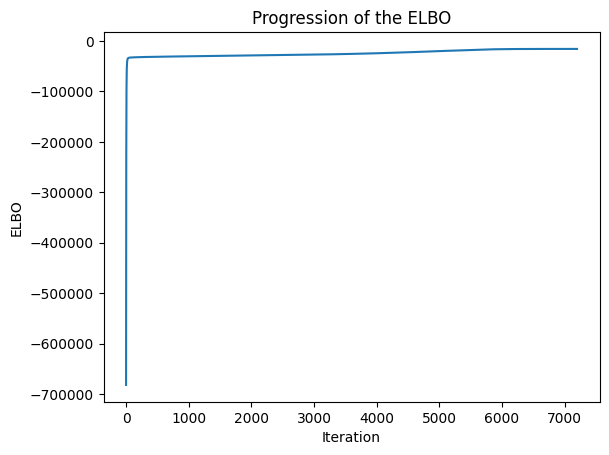

In [33]:
q.plot_elbo()

## Visualize the regression line 

In [34]:
# plot the regression line 
b = q.opt_variational_params["beta"]["mu"]

y = X.design_matrix @ b

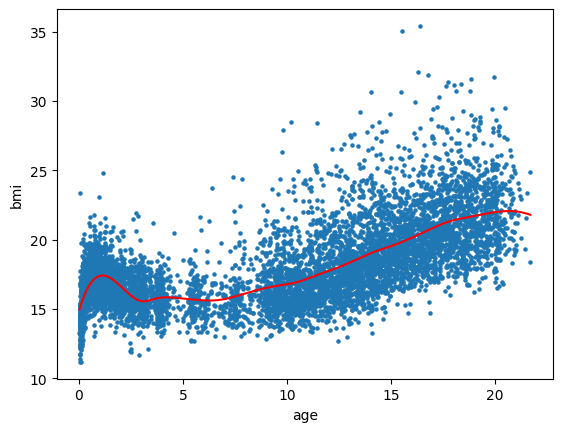

In [35]:
# plot the data
fig, ax = plt.subplots()

df.plot(kind="scatter", x="age", y="bmi", s=5, ax=ax)
ax.plot(df["age"].to_numpy(), y, color = "r")
plt.show()

In [36]:
tau = q.opt_variational_params["tau"]["mu"]

In [37]:
1/jnp.exp(tau)

Array([2.170078], dtype=float32)